In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import cmocean
from glob import glob
import pandas as pd
import seaborn as sns
sns.set()

# Load data

In [2]:
data = xr.open_dataset('ctd-data.nc')

# Plot

## Density

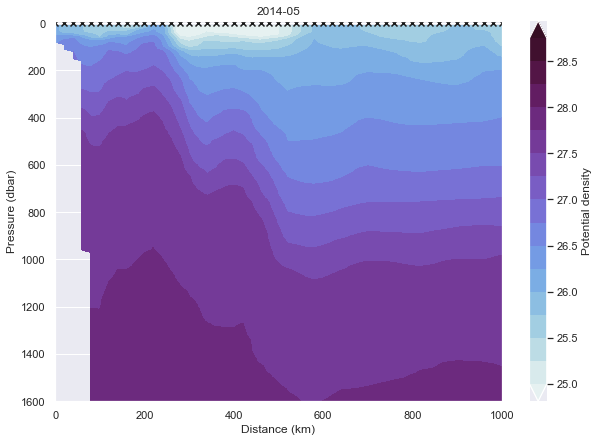

In [3]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.p, data.isel(time=i)['rho'].T, cmap='cmo.dense',
               levels=np.arange(25,29,.25), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Potential density') # create colorbar
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Temperature

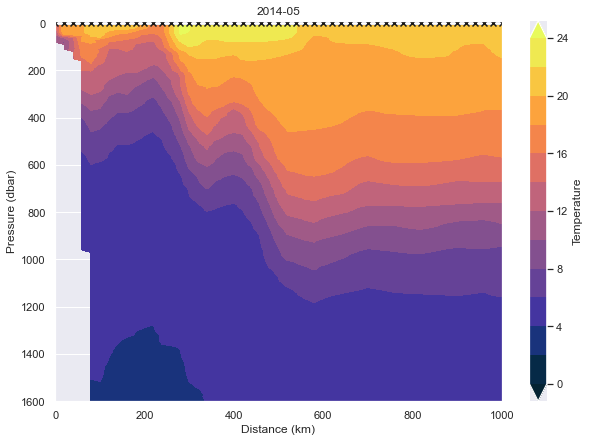

In [4]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.p, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Temperature') # create colorbar
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

# Analysis

In [6]:
def get_iso(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()

    p = plt.contour(data['dist'], data['p'], data['T'].T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(data,x):
    '''Get isotherm, and horizontal gradient of the isotherm, from data'''
    iso = get_iso(data,x)
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.interp(dist=data['dist'])
    grad  = iso.differentiate('dist')
    return iso, grad

isotherm, isograd = get_iso_xr(data.isel(time=0), 15)

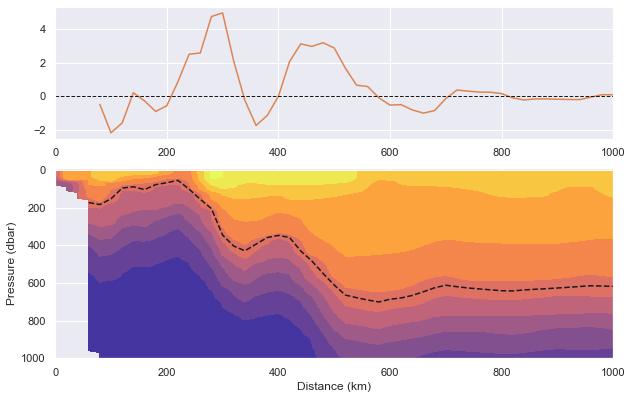

In [18]:
fig = plt.figure(figsize=(10,7))

ax0 = fig.add_subplot(2,1,1)
ax0.set_aspect(30)
ax0.plot(isograd.dist, isograd.values, color=c[1])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])

ax = fig.add_subplot(2,1,2)
p = ax.contourf(data.dist, data.p, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
# cb = fig.colorbar(p, orientation='horizontal', label=r'Temperature') # create colorbar
ax.plot(isotherm.dist, isotherm.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1000])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.subplots_adjust(hspace=0)
plt.show()

# Old code

In [ ]:
def xgrad(arr):
    '''compute the x-derivative of data in array. First column is coordinate, second is data.'''
    x,y = arr[:,0], arr[:,1]
    y_diff = y[1:]-y[:-1]
    x_diff = x[1:]-x[:-1]
    return y_diff/x_diff 

def get_iso_grad(data,x):
    '''Compute the x-derivative of an isotherm/pycnal in the given data'''
    iso = get_iso(data, x)
    return xgrad(iso)